# Residual U-Net Train (DCT Domain)

This notebook trains a residual U-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20

In [39]:
! sudo pip install --upgrade tensorflow

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement already up-to-date: tensorflow in /usr/local/lib/python2.7/dist-packages (1.13.1)


In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from skimage.util import random_noise, img_as_ubyte
from tensorflow.spectral import dct, idct

from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet, my_unet

Using TensorFlow backend.


In [3]:
! pip install --upgrade pip;  pip install nibabel scikit-image

  Using cached https://files.pythonhosted.org/packages/d8/f3/413bab4ff08e1fc4828dfc59996d721917df8e8583ea85385d51125dceff/pip-19.0.3-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Using cached https://files.pythonhosted.org/packages/0a/36/a9e7ef516d0f63c2610c0033daf06c1001b1b70943f08c89d502c19bedf6/nibabel-2.3.3-py3-none-any.whl


# MR Dataset Training

In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


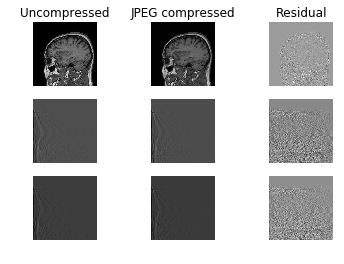

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[300])
im1_array = np.array(im1, dtype=np.float32)\

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=10)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# type must be 2 (DCT-II used in JPEG compressions)
# norm='ortho' for orthonormal normalization
im1_dct = dct(im1_array,type=2,n=None,axis=-1,norm='ortho',name=None)
im2_dct = dct(im2_array,type=2,n=None,axis=-1,norm='ortho',name=None)

dct1 = eval(im1_dct)
dct2 = eval(im2_dct)

DCT1 = DCT(im1_array)
DCT2 = DCT(im2_array)

# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure()
plt.subplot(3,3,1)
plt.imshow(im1_array, cmap="gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(3,3,2)
plt.imshow(im2_array, cmap="gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.subplot(3,3,3)
plt.imshow(im1_array - im2_array, cmap="gray")
plt.axis("off")
plt.title("Residual")
plt.subplot(3,3,4)
plt.imshow(dct1, cmap="gray")
plt.axis("off")
plt.subplot(3,3,5)
plt.imshow(dct2, cmap="gray")
plt.axis("off")
plt.subplot(3,3,6)
plt.imshow(dct1 - dct2, cmap="gray")
plt.axis("off")
plt.subplot(3,3,7)
plt.imshow(DCT1, cmap="gray")
plt.axis("off")
plt.subplot(3,3,8)
plt.imshow(DCT2, cmap="gray")
plt.axis("off")
plt.subplot(3,3,9)
plt.imshow(DCT1 - DCT2, cmap="gray")
plt.axis("off")
plt.show()

In [16]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

useNoise = False

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
train_compr = train_unc.copy()
dct_train_unc = train_unc.copy()
dct_train_compr = train_compr.copy()

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)
# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    
    im1_array = np.array(im1)

    #inject noise (s&p)
    if useNoise:
        im1_array = random_noise(im1_array, mode='s&p')
        im1_array = img_as_ubyte(im1_array)
        
    train_unc[ii,:,:,0] = im1_array
    
    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr[ii]))
    im2 = Image.open(buffer)
    train_compr[ii,:,:,0] = np.array(im2)
    

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

if compr_range[0] != compr_range[1]:
    compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)
else:
    compr_val = np.zeros(len(val_images)) + compr_range[0] # note: compr_val is a float

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2)

# train_unc /= norm
# train_compr /= norm
val_unc /= norm
val_compr /= norm

# DCT TRANSFORM
for ii in range(len(train_images)):
    dct_train_unc[ii,:,:,0] = DCT(train_unc[ii,:,:,0])
    dct_train_compr[ii,:,:,0] = DCT(train_compr[ii,:,:,0])
    #dct_train_unc[ii,:,:,0] = DCT(train_unc[ii,:,:,0], norm='ortho')
    
for ii in range(len(val_images)):
    dct_val_unc[ii,:,:,0] = DCT(val_unc[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = DCT(val_compr[ii,:,:,0])
#     dct_val_unc[ii,:,:,0] = DCT(val_unc[ii,:,:,0], norm='ortho')
#     dct_val_compr[ii,:,:,0] = DCT(val_compr[ii,:,:,0], norm='ortho')

In [5]:
# normalize
# dct_train_unc = (dct_train_unc - np.min(dct_train_unc)) / (np.max(dct_train_unc) - np.min(dct_train_unc))
# dct_train_compr = (dct_train_compr - np.min(dct_train_compr)) / (np.max(dct_train_compr) - np.min(dct_train_compr))
# dct_val_unc = (dct_val_unc - np.min(dct_val_unc)) / (np.max(dct_val_unc) - np.min(dct_val_unc))
# dct_val_compr = (dct_val_compr - np.min(dct_val_compr)) / (np.max(dct_val_compr) - np.min(dct_val_compr))

print(np.min(dct_train_unc), np.max(dct_train_unc))
print(np.min(dct_train_compr), np.max(dct_train_compr))
print(np.min(dct_val_unc), np.max(dct_val_unc))
print(np.min(dct_val_compr), np.max(dct_val_compr))

-106.89841 206.86275
-109.945724 208.83139
-104.5963 199.56079
-104.33536 198.7059


Validation set


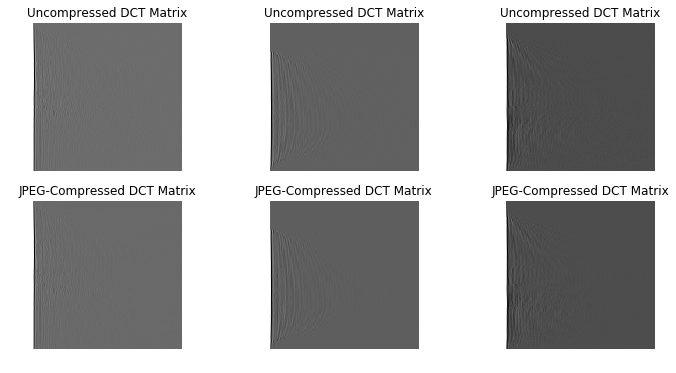

In [6]:
indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (12,6))
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(dct_val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed DCT Matrix")
    plt.subplot(2,3,ii + 4)
    plt.imshow(dct_val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed DCT Matrix")
plt.show()    


In [7]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_DCT_data_augmentation_compress_10_20-2.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


# opt = Adam(lr=0.0001)
# model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
# model.compile(loss = "mse",optimizer=opt)

opt = Adam(lr=0.0001)
model = my_unet()
model.compile(loss = "mse",optimizer=opt)

# Use pre-train network
#model.load_weights("../Models/residual_unet_data_augmentation_imagenet_compress_16_20.hdf5")

(8, 256, 256, 1)
-56.232536 113.380394
-56.111862 113.45607


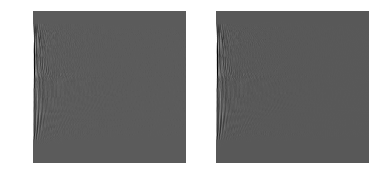

In [20]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2)
            
            dct_batch_unc[ii,:,:,0] = DCT(batch_unc[ii,:,:,0]/255.0)
            dct_batch_comp[ii,:,:,0] = DCT(batch_comp[ii,:,:,0]/255.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)


# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [21]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=dct_train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 962s 716ms/step - loss: 9.2961 - val_loss: 2.6823
Epoch 2/30
1343/1342 [==============================] - 958s 713ms/step - loss: 1.2206 - val_loss: 0.5926
Epoch 3/30
1343/1342 [==============================] - 957s 712ms/step - loss: 0.4226 - val_loss: 0.4426
Epoch 4/30
1343/1342 [==============================] - 957s 712ms/step - loss: 0.3024 - val_loss: 0.4087
Epoch 5/30
1343/1342 [==============================] - 956s 712ms/step - loss: 0.2771 - val_loss: 0.3904
Epoch 6/30
1343/1342 [==============================] - 956s 712ms/step - loss: 0.2598 - val_loss: 0.3789
Epoch 7/30
1343/1342 [==============================] - 956s 712ms/step - loss: 0.2478 - val_loss: 0.3704
Epoch 8/30
1343/1342 [==============================] - 957s 712ms/step - loss: 0.2406 - val_loss: 0.3657
Epoch 9/30
1343/1342 [==============================] - 956s 712ms/step - loss: 0.2363 - val_loss: 0.3593
Epoch 10/30
1343/1342 [=======================

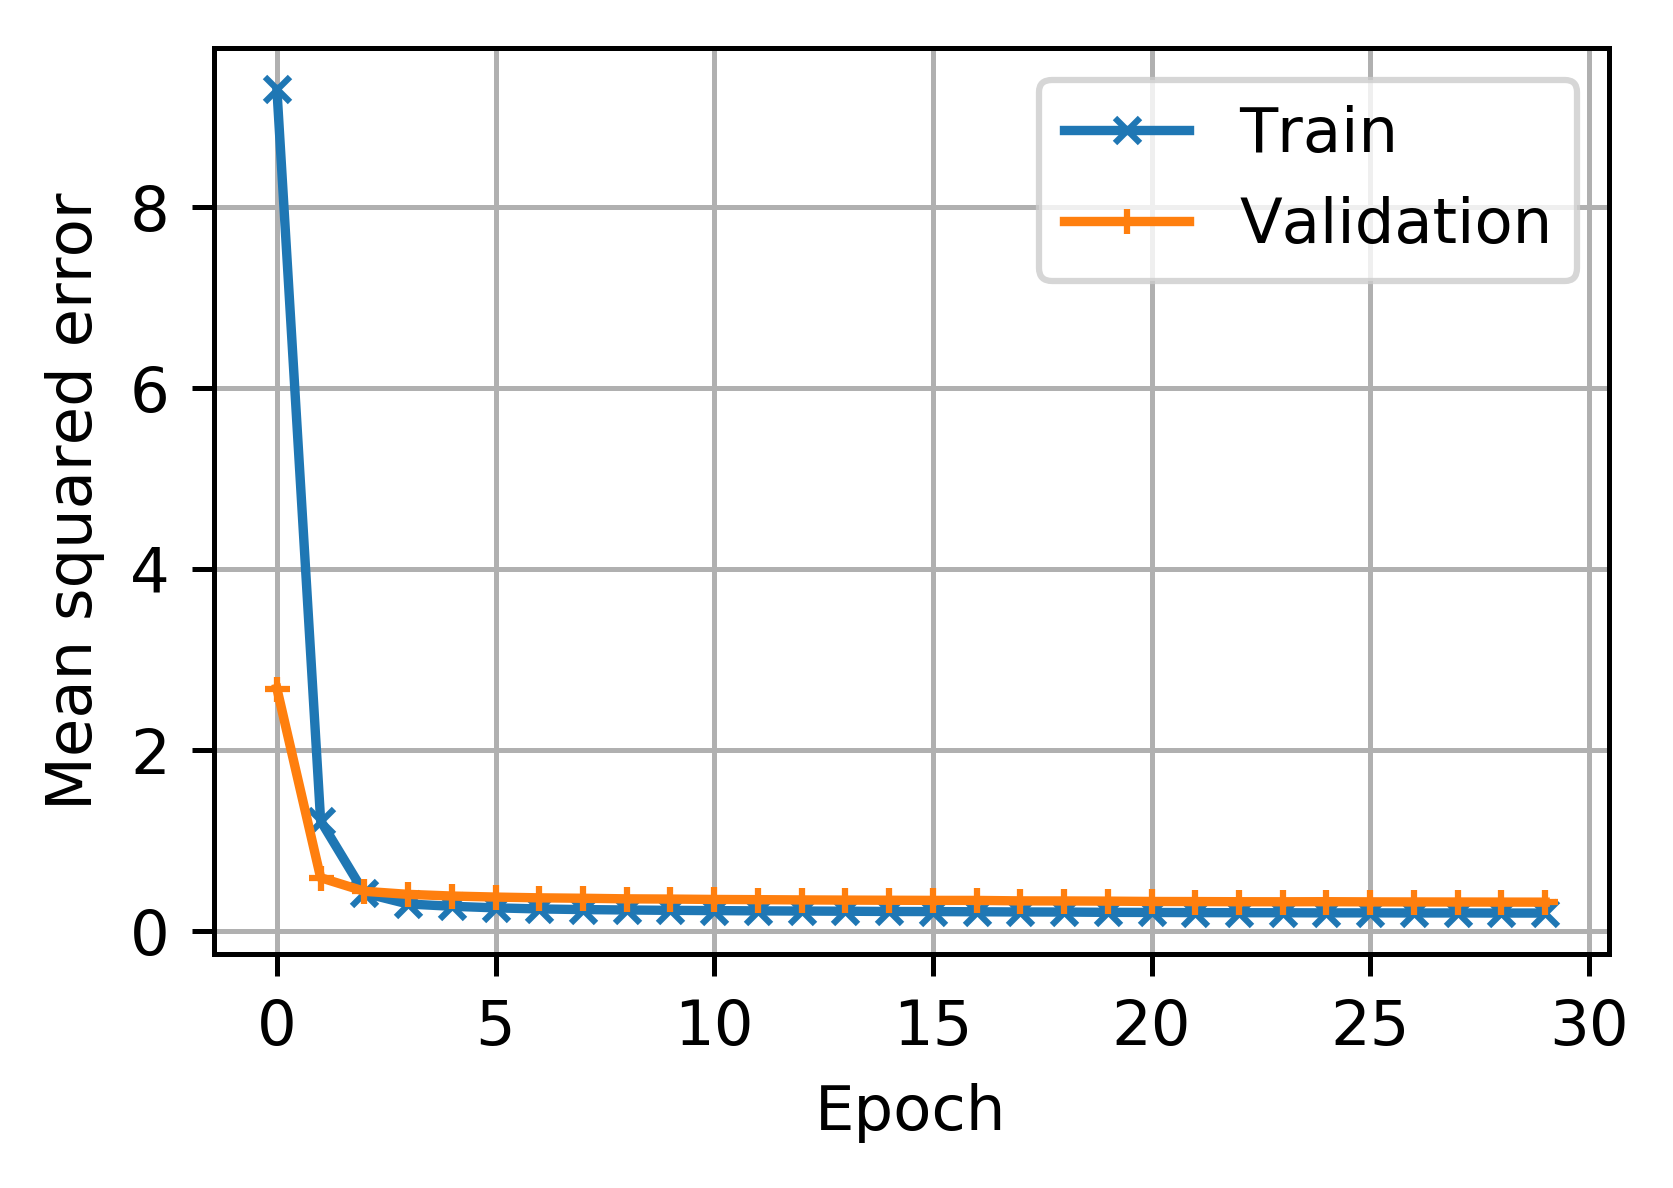

In [22]:
#Saving training history
np.save("../Data/loss_residual_unet_DCT_data_augmentation_compress_10_20-2.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_DCT_data_augmentation_compress_10_20-2.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()